In [23]:
import numpy as np
import plotly.graph_objects as go
from itertools import product
import matplotlib.pyplot as plt
from queue import PriorityQueue
import os
from PIL import Image
from tqdm import tqdm

In [2]:
ord("a"), ord("z"), ord("E"), ord("S")

(97, 122, 69, 83)

In [3]:
with open("./data_inputs/day12_input.txt") as f:
    input_raw = f.read()

hill_map = [[ord(c)-97 for c in line] for line in input_raw.split("\n")]
hill_map = np.array(hill_map)

H, W = hill_map.shape

# getting start and finish coords and setting their altitude back to 0 and 25
row, col = np.where(hill_map == -14)
start = (row[0], col[0])
row, col = np.where(hill_map == -28)
finish = (row[0], col[0])
hill_map[start[0], start[1]] = 0
hill_map[finish[0], finish[1]] = 25
start, finish

((20, 0), (20, 68))

In [33]:
fig = go.Figure(data = [go.Surface(z = hill_map)])
fig.update_layout(title="Hill map", autosize=False,
                width=900, height=600,
                margin=dict(l=40, r=40, b=40, t=40),
                scene_camera = dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=-0.2, y=0.75, z=1.20)
                    )
                )
fig.show()


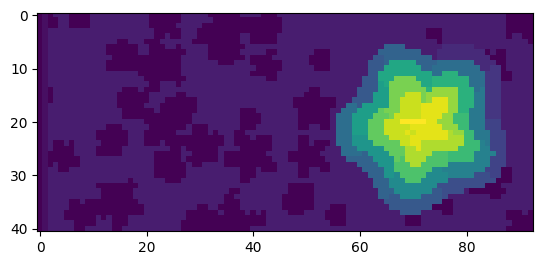

In [5]:
plt.imshow(hill_map)
plt.rcParams["figure.figsize"] = (15, 10)
plt.show()

In [6]:
# Solving a bug in my input where there are no connection points between height 7 and 9 in a point of the upwards path

hill_map[17, 59] = 8

In [7]:
def get_neighbors(pos, H, W, hill_map):
    neighbors = []
    deltas = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    for d in deltas:
        n = (pos[0] + d[0], pos[1] + d[1])
        if 0 <= n[0] < H and 0 <= n[1] < W:
            if hill_map[pos]-1 <= hill_map[n] <= hill_map[pos]+1:
                neighbors.append(n)

    return neighbors

In [8]:
class Graph:
    def __init__(self, num_of_vertices):
        self.v = num_of_vertices
        self.edges = {v: {} for v in product(range(0, H), range(0, W))}
        self.visited = []

    def add_edge(self, u, v, weight):
        self.edges[u][v] = weight
        self.edges[v][u] = weight


def dijkstra(graph, start_vertex):
    D = {v:float('inf') for v in graph.edges.keys()}
    D[start_vertex] = 0

    pq = PriorityQueue()
    pq.put((0, start_vertex))

    while not pq.empty():
        (dist, current_vertex) = pq.get()
        graph.visited.append(current_vertex)

        for neighbor in graph.edges.keys():
            if neighbor in graph.edges[current_vertex]:
                distance = graph.edges[current_vertex][neighbor]
                if neighbor not in graph.visited:
                    old_cost = D[neighbor]
                    new_cost = D[current_vertex] + distance
                    if new_cost < old_cost:
                        pq.put((new_cost, neighbor))
                        D[neighbor] = new_cost
    return D

In [9]:
def build_graph(hill_map):
    graph_vertices = hill_map.shape[0] * hill_map.shape[1]
    g = Graph(graph_vertices)

    for i in range(H):
        for j in range(W):
            pos = (i, j)
            neighbors = get_neighbors(pos, H, W, hill_map)
            for n in neighbors:
                g.add_edge(pos, n, 1)

    return g

In [10]:
# ---- Part 1 ----

g = build_graph(hill_map)

D = dijkstra(g, start)

min_dist = D[finish]

print("Result 1:", min_dist)

Result 1: 412


In [11]:
pos = finish
visited = [pos]
track_1 = {"y": [pos[0]], "x": [pos[1]]}

while pos != start:
    neighbors = get_neighbors(pos, H, W, hill_map)
    min_steps = 1000
    for n in neighbors:
        if n not in visited:
            if D[n] < min_steps:
                min_steps = D[n]
                pos = n
    
    visited.append(pos)
    track_1["y"].append(pos[0])
    track_1["x"].append(pos[1])

track_1["y"].append(start[0])
track_1["x"].append(start[1])

In [35]:
import io

x = []
y = []
frames = []

for i in tqdm(range(1, len(visited)+1)):
    x.append(track_1["x"][-i])
    y.append(track_1["y"][-i])
    
    fig = go.Figure(data = [go.Surface(z = hill_map),
                            go.Scatter3d(x=x, y=y, z=hill_map[y, x]+0.2,
                            marker=dict(
                                size=4,
                                color="lime",
                            ),
                            line=dict(
                                color='lime',
                                width=4,
                            ))
                            ])

    fig.update_layout(title="Hill map", autosize=False,
                    width=800, height=550,
                    margin=dict(l=40, r=40, b=40, t=40),
                    scene_camera = dict(
                        up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=-0.2, y=0.75, z=1.20)
                        )
                    )

    frames.append(Image.open(io.BytesIO(fig.to_image(format="png"))))

frame_one = frames[0]
frame_one.save("day12_part_1.gif", format="GIF", append_images=frames, save_all=True, duration=50, loop=0)

100%|██████████| 413/413 [08:04<00:00,  1.17s/it]


In [11]:
# ---- Part 2 ----

g = build_graph(hill_map)

D = dijkstra(g, finish)

lower_points = np.where(hill_map == 0)

min = (1000, None)
for p in zip(lower_points[0], lower_points[1]):
    if min[0] > D[p]:
        min = (D[p], p)

print("Result 2:", min[0])

Result 2: 402
